<a href="https://colab.research.google.com/github/yeondub1121/D.L-study/blob/main/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
# konlpy 설치 및 mecab 설치
!pip install konlpy
!pip install mecab-python
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Mecab
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from collections import Counter

# 데이터 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

# 데이터 불러오기
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

# 데이터 크기 출력
print("훈련용 리뷰 개수 :", len(train_data))  # 훈련용 리뷰 개수 출력

mecab-ko is already installed
mecab-ko-dic is already installed
<string>:1: DeprecationWarning: 'pkgutil.find_loader' is deprecated and slated for removal in Python 3.14; use importlib.util.find_spec() instead
mecab-python is already installed
Done.
훈련용 리뷰 개수 : 150000


In [14]:
# 상위 5개 출력
train_data[:5]

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [15]:
print("테스트용 리뷰 개수 :", len(test_data))  # 테스트용 리뷰 개수 출력

# document 열과 label 열의 중복을 제외한 값의 개수
train_data['document'].nunique(), train_data['label'].nunique()

# document 열의 중복 제거
train_data.drop_duplicates(subset=['document'], inplace=True)
print("총 샘플의 수 :", len(train_data))


테스트용 리뷰 개수 : 50000
총 샘플의 수 : 146183


   label  count
0      0  73342
1      1  72841


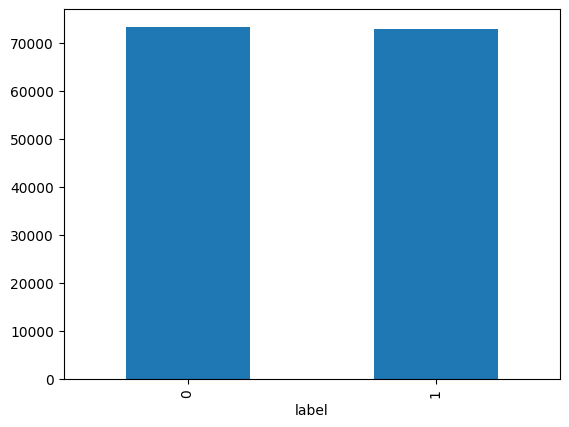

In [16]:
train_data['label'].value_counts().plot(kind='bar')
print(train_data.groupby('label').size().reset_index(name='count'))

In [17]:
# 결측치(null) 확인
print(train_data.isnull().values.any())
print(train_data.isnull().sum())

True
id          0
document    1
label       0
dtype: int64


In [18]:
# 결측치가 존재하는 행 출력
train_data.loc[train_data.document.isnull()]

,id,document,label
25857,2172111,NaN,1


In [19]:
# Null 값 제거
train_data = train_data.dropna(how='any')  # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any())     # Null 값 존재 여부 확인
print(len(train_data))

False
146182


In [20]:
# 알파벳과 공백을 제외하고 모두 제거
eng_text = "do!!! you expect... people~ to~ read~ the FAQ, etc. and actually accept hard~! atheism?@@"
print(re.sub(r"[^a-zA-Z ]", '', eng_text))

do you expect people to read the FAQ etc and actually accept hard atheism


In [21]:
# 한글과 공백을 제외하고 모두 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", regex=True)
train_data[:5]

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [22]:
# 공백만 있는 데이터 제거
train_data['document'] = train_data['document'].str.replace('^ +', "", regex=True)  # white space → empty
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

id            0
document    789
label         0
dtype: int64


/tmp/ipython-input-2166475510.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['document'].replace('', np.nan, inplace=True)


In [23]:
train_data.loc[train_data.document.isnull()][:5]
train_data = train_data.dropna(how='any')
print(len(train_data))

145393


In [24]:
# test_data 정제
test_data.drop_duplicates(subset=['document'], inplace=True)
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", regex=True)
test_data['document'] = test_data['document'].str.replace('^ +', "", regex=True)
test_data['document'].replace('', np.nan, inplace=True)
test_data = test_data.dropna(how='any')
print("전처리 후 테스트용 샘플의 개수 :", len(test_data))

전처리 후 테스트용 샘플의 개수 : 48852


/tmp/ipython-input-3184553764.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_data['document'].replace('', np.nan, inplace=True)


In [ ]:
mecab = Mecab()
mecab.morphs("와 이런 것도 영화라고 차리리 뮤직비디오로 만든는 게 나온 별"))

# 불용어 리스트
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하',
             '고', '을', '를', '인', '듯', '과', '와', '네', '들', '지', '임', '게']

# 훈련 데이터 토큰화 + 불용어 제거
X_train = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = mecab.morphs(sentence)
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords]
    X_train.append(stopwords_removed_sentence)

# 테스트 데이터 토큰화 + 불용어 제거
X_test = []
for sentence in tqdm(test_data['document']):
    tokenized_sentence = mecab.morphs(sentence)
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords]
    X_test.append(stopwords_removed_sentence)

In [ ]:
# ----------------------------
# 학습/검증/테스트 데이터 분리
# ----------------------------
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.2, random_state=0, stratify=y_train
)

print('-----------훈련 데이터의 비율-----------')
print('부정 리뷰 비율 :', round(np.sum(y_train==0)/len(y_train) * 100, 3), '%')
print('긍정 리뷰 비율 :', round(np.count_nonzero(y_train)/len(y_train) * 100, 3), '%')

print('\n-----------검증 데이터의 비율-----------')
print('부정 리뷰 비율 :', round(np.sum(y_valid==0)/len(y_valid) * 100, 3), '%')
print('긍정 리뷰 비율 :', round(np.count_nonzero(y_valid)/len(y_valid) * 100, 3), '%')

print('\n-----------테스트 데이터의 비율-----------')
print('부정 리뷰 비율 :', round(np.sum(y_test==0)/len(y_test) * 100, 3), '%')
print('긍정 리뷰 비율 :', round(np.count_nonzero(y_test)/len(y_test) * 100, 3), '%')


In [ ]:
# ----------------------------
# 단어 빈도수 확인
# ----------------------------
from collections import Counter

word_list = []
for sent in X_train:
    for word in sent:
        word_list.append(word)

word_counts = Counter(word_list)
print('총 단어수 :', len(word_counts))

print('훈련 데이터에서 "영화" 등장 횟수 :', word_counts['영화'])
print('훈련 데이터에서 "공감" 등장 횟수 :', word_counts['공감'])

# 등장 빈도수 상위 10개 단어 출력
vocab = sorted(word_counts, key=word_counts.get, reverse=True)
print('등장 빈도수 상위 10개 단어 :')
print(vocab[:10])


In [ ]:
# ----------------------------
# 희귀 단어 비율 계산
# ----------------------------
threshold = 3
total_cnt = len(word_counts)
rare_cnt = 0
total_freq = 0
rare_freq = 0

for key, value in word_counts.items():
    total_freq += value
    if value < threshold:
        rare_cnt += 1
        rare_freq += value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수 :' % (threshold - 1), rare_cnt)
print('희귀 단어 비율 :', (rare_cnt / total_cnt) * 100)
print('전체 단어 중 희귀 단어 등장 비율 :', (rare_freq / total_freq) * 100)

# 희귀 단어 제거 후 단어 집합 크기
vocab_size = total_cnt - rare_cnt
vocab = vocab[:vocab_size]
print('단어의 집합의 크기 :', len(vocab))

In [ ]:
# ----------------------------
# 단어 인덱싱 & 시퀀스 변환
# ----------------------------
word_to_index = {'<PAD>': 0, '<UNK>': 1}
for index, word in enumerate(vocab):
    word_to_index[word] = index + 2

vocab_size = len(word_to_index)
print("패딩 토큰과 UNK 토큰을 고려한 단어 집합의 크기 :", vocab_size)

print('단어 <PAD>와 매핑되는 정수 :', word_to_index['<PAD>'])
print('단어 <UNK>와 매핑되는 정수 :', word_to_index['<UNK>'])
print('단어 영화와 매핑되는 정수 :', word_to_index['영화'])

def texts_to_sequences(tokenized_X_data, word_to_index):
    encoded_X_data = []
    for sent in tokenized_X_data:
        index_sequence = []
        for word in sent:
            index_sequence.append(word_to_index.get(word, word_to_index['<UNK>']))
        encoded_X_data.append(index_sequence)
    return encoded_X_data

encoded_X_train = texts_to_sequences(X_train, word_to_index)
encoded_X_valid = texts_to_sequences(X_valid, word_to_index)
encoded_X_test = texts_to_sequences(X_test, word_to_index)

# 인덱스 → 단어 복원용
index_to_word = {v: k for k, v in word_to_index.items()}
print(encoded_X_train[:2])


In [ ]:
# ----------------------------
# 문장 길이 확인 및 시각화
# ----------------------------
decoded_sample = [index_to_word[word] for word in encoded_X_train[0]]
print('기존의 첫번째 샘플 :', X_train[0])
print('복원된 첫번째 샘플 :', decoded_sample)

print('리뷰의 최대 길이 :', max(len(r) for r in encoded_X_train))
print('리뷰의 평균 길이 :', sum(map(len, encoded_X_train)) / len(encoded_X_train))

plt.hist([len(r) for r in encoded_X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

def below_threshold_len(max_len, nested_list):
    count = sum(1 for sentence in nested_list if len(sentence) <= max_len)
    print(f"전체 샘플 중 길이가 {max_len} 이하인 샘플의 비율: {(count / len(nested_list)) * 100:.2f}%")

max_len = 30
below_threshold_len(max_len, encoded_X_train)

In [ ]:
# ----------------------------
# 시퀀스 패딩
# ----------------------------
def pad_sequences(sentences, max_len):
    features = np.zeros((len(sentences), max_len), dtype=int)
    for i, sentence in enumerate(sentences):
        features[i, :len(sentence)] = np.array(sentence)[:max_len]
    return features

padded_X_train = pad_sequences(encoded_X_train, max_len)
padded_X_valid = pad_sequences(encoded_X_valid, max_len)
padded_X_test = pad_sequences(encoded_X_test, max_len)

print("훈련 데이터의 크기 :", padded_X_train.shape)
print("검증 데이터의 크기 :", padded_X_valid.shape)
print("테스트 데이터의 크기 :", padded_X_test.shape)
print("첫번째 샘플 :", padded_X_train[0])


In [ ]:
# ----------------------------
# 텐서 변환 및 장치 설정
# ----------------------------
import torch
import torch.nn as nn
import torch.nn.functional as F

train_label_tensor = torch.tensor(y_train)
valid_label_tensor = torch.tensor(y_valid)
test_label_tensor = torch.tensor(y_test)

USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print("cpu와 cuda 중 다음 기기로 학습함:", device)

In [ ]:
# ----------------------------
# LSTM 기반 감정 분류 모델
# ----------------------------
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(TextClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, (hidden, cell) = self.lstm(embedded)
        last_hidden = hidden.squeeze(0)
        logits = self.fc(last_hidden)
        return logits

In [ ]:
# ----------------------------
# 데이터로더 준비
# ----------------------------
encoded_train = torch.tensor(padded_X_train).to(torch.int64)
encoded_valid = torch.tensor(padded_X_valid).to(torch.int64)
encoded_test = torch.tensor(padded_X_test).to(torch.int64)

train_dataset = torch.utils.data.TensorDataset(encoded_train, train_label_tensor)
valid_dataset = torch.utils.data.TensorDataset(encoded_valid, valid_label_tensor)
test_dataset = torch.utils.data.TensorDataset(encoded_test, test_label_tensor)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

In [ ]:
# ----------------------------
# 학습 설정
# ----------------------------
embedding_dim = 100
hidden_dim = 128
output_dim = 2
num_epochs = 10

model = TextClassifier(vocab_size, embedding_dim, hidden_dim, output_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# ----------------------------
# 정확도 / 평가 함수
# ----------------------------
def calculate_accuracy(logits, labels):
    predicted = torch.argmax(logits, dim=1)
    correct = (predicted == labels).sum().item()
    return correct / labels.size(0)

def evaluate(model, dataloader, criterion, device):
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for batch_X, batch_y in dataloader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            logits = model(batch_X)
            loss = criterion(logits, batch_y)
            val_loss += loss.item()
            val_correct += (torch.argmax(logits, dim=1) == batch_y).sum().item()
            val_total += batch_y.size(0)
    return val_loss / len(dataloader), val_correct / val_total

In [ ]:
# ----------------------------
# 학습 루프
# ----------------------------
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0

    for batch_X, batch_y in train_dataloader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        logits = model(batch_X)
        loss = criterion(logits, batch_y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_correct += (torch.argmax(logits, dim=1) == batch_y).sum().item()
        train_total += batch_y.size(0)

    train_accuracy = train_correct / train_total
    val_loss, val_accuracy = evaluate(model, valid_dataloader, criterion, device)

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {train_loss/len(train_dataloader):.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    if val_loss < best_val_loss:
        print(f"Validation Loss improved from {best_val_loss:.4f} to {val_loss:.4f}. 체크포인트 저장.")
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model_checkpoint.pth')

In [ ]:
# ----------------------------
# 모델 로드 및 평가
# ----------------------------
model.load_state_dict(torch.load('best_model_checkpoint.pth'))
model.to(device)

val_loss, val_acc = evaluate(model, valid_dataloader, criterion, device)
test_loss, test_acc = evaluate(model, test_dataloader, criterion, device)

print(f"Best model validation loss: {val_loss:.4f}, accuracy: {val_acc:.4f}")
print(f"Best model test loss: {test_loss:.4f}, accuracy: {test_acc:.4f}")

In [ ]:
# ----------------------------
# 감정 예측 함수
# ----------------------------
index_to_tag = {0: '부정', 1: '긍정'}

def predict(text, model, word_to_index, index_to_tag):
    model.eval()
    tokens = mecab.morphs(text)
    tokens = [w for w in tokens if w not in stopwords]
    token_indices = [word_to_index.get(w, word_to_index['<UNK>']) for w in tokens]
    input_tensor = torch.tensor([token_indices], dtype=torch.long).to(device)
    with torch.no_grad():
        logits = model(input_tensor)
        pred_index = torch.argmax(logits, dim=1).item()
    return index_to_tag[pred_index]

# 테스트
print(predict("이 영화 개꿀잼 ㅋㅋㅋ", model, word_to_index, index_to_tag))
print(predict("이딴게 영화냐 ㅉㅉ", model, word_to_index, index_to_tag))
print(predict("감독 뭐하는 놈이냐?", model, word_to_index, index_to_tag))
print(predict("와 개쩐다 정말 세계관 최강자들의 영화다", model, word_to_index, index_to_tag))
